In [30]:
import sys
import os 
sys.path.append('..')
sys.path.append('../..')
sys.path.append('../../..')

from learning.collections_env.collections_env import CollectionsEnv, MAX_ACCOUNT_BALANCE
from learning.utils.wrappers import DiscretizedActionWrapper, StateNormalization
from learning.policies.dqn import DQNAgent, DefaultConfig
from learning.policies.dqn_lattice import DQNAgentLattice
from learning.utils import misc

import os
import numpy as np
import pickle
import keras
import tensorflow as tf
from keras.models import Sequential, load_model, Model
from keras.layers import Dense
from keras.optimizers import Adam
from keras import backend as K

import tensorflow_lattice as tfl

from IPython.display import HTML, clear_output

import matplotlib.pyplot as plt

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"



In [31]:
name = 'DQNLattice'
log_path = os.path.join(misc.RESOURCE_ROOT, 'models', name)
logs = os.listdir(log_path)
logs

['20200701-174019', '20200705-175700', '20200707-111615']

In [32]:
log_num = -1
models = os.listdir(os.path.join(misc.RESOURCE_ROOT, 'models', name, logs[log_num]))
actions_bins = np.load(os.path.join(misc.RESOURCE_ROOT, 'models', name, logs[log_num], 'action_bins.npy'))
model_path = os.path.join(misc.RESOURCE_ROOT, 'models', name, logs[log_num])
try:
    buffer_path = os.path.join(misc.RESOURCE_ROOT, 'models', name, logs[log_num], 'buffer.pkl')
except:
    print('No buffer found.')
    
with open(buffer_path,'rb') as f:
    buffer = pickle.load(f)

In [33]:
os.listdir(model_path)

['action_bins.npy', 'buffer.pkl', 'main_net.h5']

In [34]:
# actions_bins = np.array([0, 0.1, 1])
# actions_bins = np.array([0, 0.2])
# actions_bins = np.array([0, 0.5])
n_actions = len(actions_bins)
c_env = CollectionsEnv(continuous_reward=False)
environment = DiscretizedActionWrapper(c_env, actions_bins)
# environment = StateNormalization(environment)
sample_obs = environment.reset()

Setting
New action space: Discrete(2)


In [35]:
config = DefaultConfig()
agent = DQNAgentLattice(environment, 'DDQN', training=False, config=DefaultConfig(), initialize=False)
agent.main_net.predict_on_batch(sample_obs[None,:])
agent.target_net.predict_on_batch(sample_obs[None,:])
agent.load(model_path)

In [45]:
w_points = 60
l_points = 60

# w_normalized = np.linspace(0, 1, w_points)
# l_normalized = np.linspace(0, 1, l_points)
l = np.linspace(environment.observation_space.low[0], environment.observation_space.high[0], l_points)
w = np.linspace(environment.observation_space.low[1], environment.observation_space.high[1], w_points)
wwn, lln = np.meshgrid(w_normalized, l_normalized)
ww, ll = np.meshgrid(w, l)
z = np.zeros_like(ww)
p = np.zeros_like(ww)
for i, xp in enumerate(w):
    for j, yp in enumerate(l):
        fixed_obs = np.array([yp, xp])
        z[j, i] = np.amax(agent.main_net.predict_on_batch(fixed_obs[None, :]))
        p[j, i] = environment.action(np.argmax(agent.main_net.predict_on_batch(fixed_obs[None,:])))

In [46]:
z

array([[103.58959198, 103.58969879, 103.59036255, ..., 471.26980591,
        471.28692627, 471.30404663],
       [103.58961487, 103.58972168, 103.59082031, ..., 476.91351318,
        476.93179321, 476.95016479],
       [103.58961487, 103.58973694, 103.59127045, ..., 483.83908081,
        483.8578186 , 483.87667847],
       ...,
       [118.64372253, 120.36295319, 152.43043518, ..., 799.99957275,
        799.99957275, 799.99957275],
       [119.36638641, 122.11114502, 208.33724976, ..., 799.99963379,
        799.99963379, 799.99963379],
       [120.1908493 , 136.81867981, 298.4883728 , ..., 799.99975586,
        799.99975586, 799.99975586]])

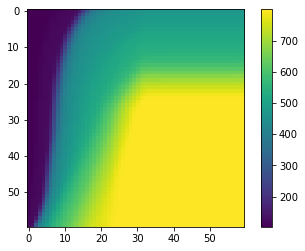

In [47]:
fig, ax = plt.subplots()
im = ax.imshow(z)
fig.colorbar(im)

Text(0.5, 1.0, 'Simplest default with labels')

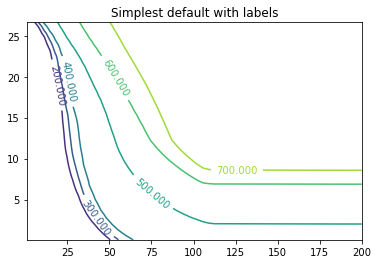

In [48]:
fig, ax = plt.subplots()
CS = ax.contour(ww, ll, z)
ax.clabel(CS, inline=1, fontsize=10)
ax.set_title('Simplest default with labels')

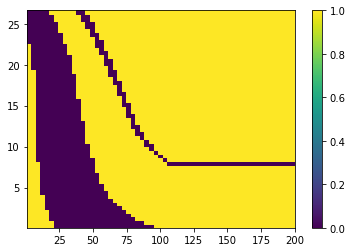

In [49]:
plt.pcolor(ww, ll, p)
plt.colorbar()
plt.show()

Text(0.5, 1.0, 'Simplest default with labels')

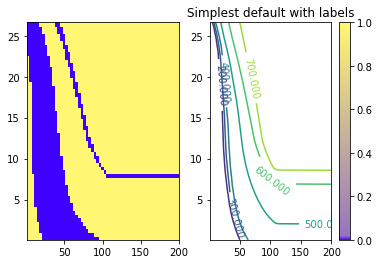

In [50]:
import matplotlib as m
fig, ax = plt.subplots(nrows=1, ncols=2)
im = ax[0].pcolor(ww, ll, p)
cdict = {
  'red'  :  ( (0.0, 0.25, .25), (0.02, .59, .59), (1., 1., 1.)),
  'green':  ( (0.0, 0.0, 0.0), (0.02, .45, .45), (1., .97, .97)),
  'blue' :  ( (0.0, 1.0, 1.0), (0.02, .75, .75), (1., 0.45, 0.45))
}

cm = m.colors.LinearSegmentedColormap('my_colormap', cdict, 1024)
im = ax[0].pcolor(ww, ll, p, cmap=cm)
fig.colorbar(im)

CS = ax[1].contour(ww, ll, z)
ax[1].clabel(CS, inline=1, fontsize=10)
ax[1].set_title('Simplest default with labels')


In [52]:
w_points = 60
l_points = 60
lam_lim = 3
l = np.linspace(environment.observation_space.low[0], lam_lim, l_points)
w = np.linspace(environment.observation_space.low[1], environment.observation_space.high[1], w_points)
wwn, lln = np.meshgrid(w_normalized, l_normalized)
ww, ll = np.meshgrid(w, l)
z = np.zeros_like(ww)
p = np.zeros_like(ww)
for i, xp in enumerate(w):
    for j, yp in enumerate(l):
        fixed_obs = np.array([yp, xp])
        z[j, i] = np.amax(agent.main_net.predict_on_batch(fixed_obs[None, :]))
        p[j, i] = environment.action(np.argmax(agent.main_net.predict_on_batch(fixed_obs[None,:])))

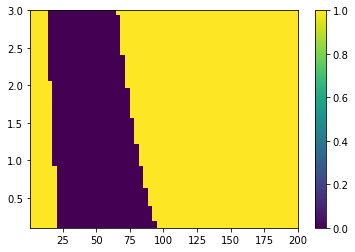

In [54]:
plt.pcolor(ww, ll, p)
plt.colorbar()
plt.show()

[INFO] [2020-07-07 15:13:48,478] [AAV] - Instantiated @ AAV
[INFO] [2020-07-07 15:13:48,491] [OAV] - Launching the value function procedure.
[INFO] [2020-07-07 15:13:48,491] [OAV] - Computing the value function on (0.00, 16.83].
[INFO] [2020-07-07 15:13:48,496] [OAV] - Computing the value function on (16.83, 18.70].
[INFO] [2020-07-07 15:13:49,265] [OAV] - Computing the value function on (18.70, 20.78].
[INFO] [2020-07-07 15:13:49,893] [OAV] - Computing the value function on (20.78, 23.08].
[INFO] [2020-07-07 15:13:50,306] [OAV] - Computing the value function on (23.08, 25.65].
[INFO] [2020-07-07 15:13:50,557] [OAV] - Computing the value function on (25.65, 28.50].
[INFO] [2020-07-07 15:13:51,251] [OAV] - Computing the value function on (28.50, 31.66].
[INFO] [2020-07-07 15:13:51,474] [OAV] - Computing the value function on (31.66, 35.18].
[INFO] [2020-07-07 15:13:52,219] [OAV] - Computing the value function on (35.18, 39.09].
[INFO] [2020-07-07 15:13:52,797] [OAV] - Computing the valu

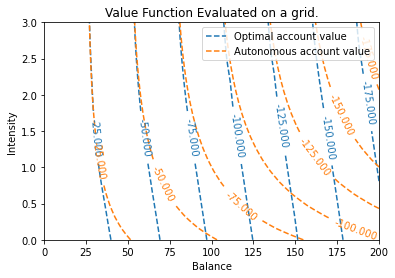

In [57]:
from dcc import OAV, Parameters, AAV
p = Parameters()
w_start = MAX_ACCOUNT_BALANCE
oav = OAV(p, w_start, lmax=3)
oav.solve_v()
fig, ax = oav.plot_vf(plot_aav_flag=True)

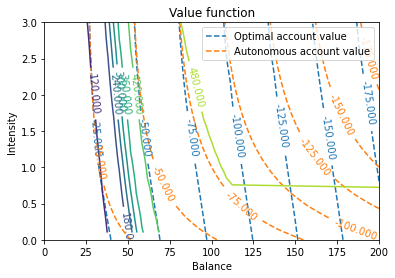

In [58]:
CS = ax.contour(ww, ll, z)
ax.clabel(CS, inline=1, fontsize=10)
ax.set_title('Value function')
fig

# Exploration of statespace

In [60]:
visits = [trans.s for trans in buffer]
visits_w = np.array([vis[1] for vis in visits])
visits_l = np.array([vis[0] for vis in visits])

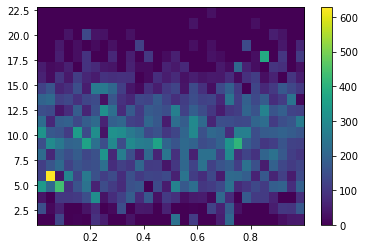

In [115]:

import numpy as np
import numpy.random
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
# Generate some test data
mask = visits_w > 0

x = visits_w[mask]
y = visits_l[mask]

# fig,ax = plt.subplots(figsize=(10,10))

heatmap, xedges, yedges = np.histogram2d(x, y, bins=(30,20))
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

# fig.clf()
mappable = ax.imshow(heatmap.T, extent=extent, origin='lower', interpolation='nearest', aspect='auto')
fig.colorbar(mappable)


In [173]:
visits_l

array([ 6.5932093,  6.5932093,  6.5932093, ..., 15.328    , 15.328    ,
       15.328    ], dtype=float32)

In [168]:
x = np.random.normal(2, 1, 100)
y = np.random.normal(1, 1, 100)
H, xedges, yedges = np.histogram2d(x, y, bins=(xedges, yedges))
H = H.T  # Let each row list bins with common y range.

fig, ax = plt.subplots()
im = m.image.NonUniformImage(ax, interpolation='bilinear')
xcenters = (xedges[:-1] + xedges[1:]) / 2
ycenters = (yedges[:-1] + yedges[1:]) / 2
im.set_data(xcenters, ycenters, H)
ax.images.append(im)
# plt.show()

TypeError: cannot unpack non-iterable NoneType object

<Figure size 432x288 with 1 Axes>

In [162]:
im.axes

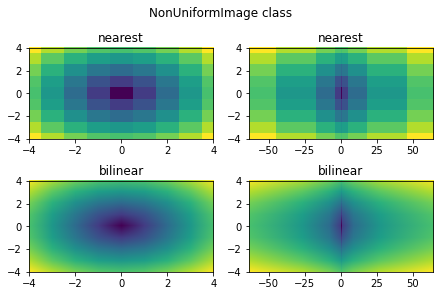

In [158]:
from matplotlib.image import NonUniformImage
interp = 'nearest'

# Linear x array for cell centers:
x = np.linspace(-4, 4, 9)

# Highly nonlinear x array:
x2 = x**3

y = np.linspace(-4, 4, 9)

z = np.sqrt(x[np.newaxis, :]**2 + y[:, np.newaxis]**2)

fig, axs = plt.subplots(nrows=2, ncols=2, constrained_layout=True)
fig.suptitle('NonUniformImage class', fontsize='large')
ax = axs[0, 0]
im = NonUniformImage(ax, interpolation=interp, extent=(-4, 4, -4, 4))
im.set_data(x, y, z)
ax.images.append(im)
ax.set_xlim(-4, 4)
ax.set_ylim(-4, 4)
ax.set_title(interp)

ax = axs[0, 1]
im = NonUniformImage(ax, interpolation=interp, extent=(-64, 64, -4, 4))
im.set_data(x2, y, z)
ax.images.append(im)
ax.set_xlim(-64, 64)
ax.set_ylim(-4, 4)
ax.set_title(interp)

interp = 'bilinear'

ax = axs[1, 0]
im = NonUniformImage(ax, interpolation=interp, extent=(-4, 4, -4, 4))
im.set_data(x, y, z)
ax.images.append(im)
ax.set_xlim(-4, 4)
ax.set_ylim(-4, 4)
ax.set_title(interp)

ax = axs[1, 1]
im = NonUniformImage(ax, interpolation=interp, extent=(-64, 64, -4, 4))
im.set_data(x2, y, z)
ax.images.append(im)
ax.set_xlim(-64, 64)
ax.set_ylim(-4, 4)
ax.set_title(interp)

plt.show()

## Policy Value

In [66]:
rewards = agent.evaluate(500)

Avg. reward over 500 episodes: 96.8151


[INFO] [2020-07-07 15:15:54,666] [AAV] - Instantiated @ AAV


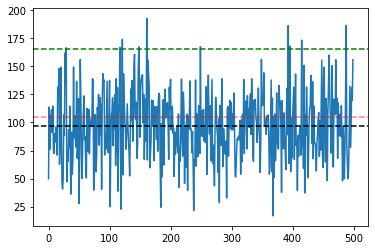

In [67]:
from dcc import AAV, Parameters
p = Parameters()
aav = AAV(p)

plt.plot(rewards)
plt.axhline(np.mean(rewards), color='black', linestyle='--')
plt.axhline(-aav.u(0.11, MAX_ACCOUNT_BALANCE), color='red', linestyle='--', alpha=0.5)
plt.axhline(-aav.u(4.5, MAX_ACCOUNT_BALANCE) - 4.5*p.c, color='green', linestyle='--')

# Calibrators

In [31]:
tfl.estimators.get_model_graph(os.path.join(model_path,'main_net.h5'))

OSError: SavedModel file does not exist at: C:\Users\majke\OneDrive\Projects\credit_collections_rl\learning\resources\models\DQNLattice\20200701-174019\main_net.h5/{saved_model.pbtxt|saved_model.pb}

In [29]:
model_path

'C:\\Users\\majke\\OneDrive\\Projects\\credit_collections_rl\\learning\\resources\\models\\DQNLattice\\20200701-174019'